In [1]:
%env

{'CLICOLOR': '1',
 'COPERNICUS_PASSWORD': 'Z9lj3uak',
 'COPERNICUS_USER': 'yutsuo',
 'GIT_PAGER': 'cat',
 'HOME': '/root',
 'HOSTNAME': 'c75793e91628',
 'JPY_PARENT_PID': '11',
 'LANG': 'C.UTF-8',
 'MPLBACKEND': 'module://ipykernel.pylab.backend_inline',
 'PAGER': 'cat',
 'PASSWORD': 'flaviostutz',
 'PATH': '/usr/local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
 'PWD': '/tf',
 'SHLVL': '1',
 'SPARK_MASTER': 'spark-master',
 'SUPERVISOR_ENABLED': '1',
 'SUPERVISOR_GROUP_NAME': 'jupyter',
 'SUPERVISOR_PROCESS_NAME': 'jupyter',
 'SUPERVISOR_SERVER_URL': 'unix:///var/run/supervisor.sock',
 'TERM': 'xterm-color',
 '_': '/usr/local/bin/jupyter'}

In [8]:
import requests

response = requests.get('http://scihub.copernicus.eu/')

print(response)

<Response [502]>


In [4]:
import matplotlib.patches as mpatches
from osgeo import gdal, osr
import cartopy.crs as ccrs
import numpy as np

def showGeoTiffs(geoTiffFiles, geometries=None, labels=None, cols=4, size=6, cmap=None, cmap_min=None, cmap_max=None, interpolation=None, legendHandles=None, group_by_label=False, name='image', output_dir=None, transformData=None):
    """geometries - list of geoseries from GeoPandas
       labels - list os strings
       getTiffFiles - list of tiff file paths
    """
    logger.info('showing ' + str(len(geoTiffFiles)) + ' images')
    fig = plt.figure()
    rows = int(len(geoTiffFiles)/cols)+1
    t = Timer('generating image patches. rows=' + str(rows) + '; cols=' + str(cols))
    fig.set_size_inches(cols*size, rows*size)

    image_indexes = range(len(geoTiffFiles))

    #order indexes by label
    if(group_by_label==True and image_labels!=None):
        index_label_map = []
        for i,label in enumerate(image_labels):
            index_label_map.append((i,label))
        label_image_map = np.array(index_label_map, dtype=[('index',int),('label',int)])
        label_image_map = np.sort(label_image_map, order='label')
        image_indexes = []
        for a in label_image_map:
            image_indexes.append(a[0])

    c = 0
    for i in image_indexes:
        ds = gdal.Open(geoTiffFiles[i])
        data = ds.ReadAsArray()
        gt = ds.GetGeoTransform()
        proj = ds.GetProjection()

        inproj = osr.SpatialReference()
        inproj.ImportFromWkt(proj)

        projcs = inproj.GetAuthorityCode('PROJCS')
        projection = ccrs.epsg(projcs)

        ax = fig.add_subplot(rows,cols,c+1, projection=projection)

        extent = (gt[0], gt[0] + ds.RasterXSize * gt[1],
                  gt[3] + ds.RasterYSize * gt[5], gt[3])

        
        #seems like this data has multiple channels and the channels area indexed from the first position. invert it
        if data.shape[0]<5:
            data = data[:3, :, :].transpose((1, 2, 0))
        else:
            if transformData!=None:
                data = transformData(data)

        if data.dtype in [np.uint8, np.uint16, np.uint32]:
            if cmap_min==None:
                cmap_min = np.iinfo(data.dtype).min
            if cmap_max==None:
                cmap_max = np.iinfo(data.dtype).max
#         if(cmap==None):
#             data = data.astype('uint8')
                
        ax.imshow(data, alpha=1.0, transform=projection, extent=extent, cmap=cmap, vmin=cmap_min, vmax=cmap_max, interpolation=interpolation, origin='upper')
        if legendHandles!=None:
            ax.legend(handles=legendHandles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        if(geometries!=None):
            df_epsg = geometries[i].to_crs(epsg=ax.projection.epsg_code)
            df_epsg.plot(ax=ax, facecolor='none', edgecolor='black', linestyle='--', linewidth=2)
        
        if(labels!=None):
            ax.text(0.5, 0, str(labels[i]), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=14, style='normal', color='red')

        c = c + 1
    
    if(output_dir!=None):
        f = output_dir + name + '.jpg'
        plt.savefig(f)
        plt.close(fig)
    else:
        plt.show()
        
    t.stop()

def sclColors():
    colors = ['black','red','dimgray','brown','green','yellow','blue','dimgray','darkgray','lightgray','skyblue','magenta']
    return colors

def sclLegendPatches():
    colors = sclColors()
    labels = ['no data','defective','dark area','cloud shadows','vegetation','not vegetated','water','unclassified','cloud medium prob','cloud high prob','thin cirrus','snow']
    patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(11) ]
    return patches


INFO:sentinelloader:Getting region history for band TCI from 2019-04-15 to 2019-04-30 at 20m
DEBUG:sentinelloader:2019-04-15 00:00:00
DEBUG:sentinelloader:Getting contents. band=TCI, resolution=20m, date=2019-04-15
DEBUG:sentinelloader:Querying API for candidate tiles
DEBUG:sentinelloader:Using cached API query contents
DEBUG:sentinelloader:Found 2 products
DEBUG:sentinelloader:Tiles selected for covering the entire desired area: [1]
DEBUG:sentinelloader:Reusing cached metadata info for tile 'e23b7888-c55f-462d-9889-cb37b7fc6a30'
INFO:sentinelloader:Downloading tile uuid='e23b7888-c55f-462d-9889-cb37b7fc6a30', resolution='20m', band='TCI', date='2019-04-13'
DEBUG:sentinelloader:Downloading https://scihub.copernicus.eu/dhus/odata/v1/Products('e23b7888-c55f-462d-9889-cb37b7fc6a30')/Nodes('S2B_MSIL2A_20190413T133229_N0211_R081_T22LHH_20190413T173342.SAFE')/Nodes('GRANULE')/Nodes('L2A_T22LHH_A010975_20190413T133229')/Nodes('IMG_DATA')/Nodes('R20m')/Nodes('T22LHH_20190413T133229_TCI_20m.jp2

[==================================================]

DEBUG:sentinelloader:Removing near black compression artifacts
DEBUG:sentinelloader:Cropping polygon from 1 files
DEBUG:sentinelloader:Combining tiles into a single image. sources=/notebooks/data/output/sentinelcache/products/2019-04-13/e23b7888-c55f-462d-9889-cb37b7fc6a30/T22LHH_20190413T133229_TCI_20m.tiff tmpfile=/notebooks/data/output/sentinelcache/tmp/f34e18da97194d5cb40ca5201abe703d.tiff
DEBUG:sentinelloader:2019-04-20 00:00:00
DEBUG:sentinelloader:Getting contents. band=TCI, resolution=20m, date=2019-04-20
DEBUG:sentinelloader:Querying API for candidate tiles
DEBUG:sentinelloader:Using cached API query contents
DEBUG:sentinelloader:Found 1 products
DEBUG:sentinelloader:Tiles selected for covering the entire desired area: [0]
DEBUG:sentinelloader:Reusing cached metadata info for tile 'f7ba0308-41e2-4cee-b3ce-5199af7de222'
INFO:sentinelloader:Downloading tile uuid='f7ba0308-41e2-4cee-b3ce-5199af7de222', resolution='20m', band='TCI', date='2019-04-18'
DEBUG:sentinelloader:Downloadi

[==================================================]

DEBUG:sentinelloader:Removing near black compression artifacts
DEBUG:sentinelloader:Cropping polygon from 1 files
DEBUG:sentinelloader:Combining tiles into a single image. sources=/notebooks/data/output/sentinelcache/products/2019-04-18/f7ba0308-41e2-4cee-b3ce-5199af7de222/T22LHH_20190418T133231_TCI_20m.tiff tmpfile=/notebooks/data/output/sentinelcache/tmp/5394fea7367d4dbda4594e751b1ccc9d.tiff
DEBUG:sentinelloader:2019-04-25 00:00:00
DEBUG:sentinelloader:Getting contents. band=TCI, resolution=20m, date=2019-04-25
DEBUG:sentinelloader:Querying API for candidate tiles
DEBUG:sentinelloader:Using cached API query contents
DEBUG:sentinelloader:Found 2 products
DEBUG:sentinelloader:Tiles selected for covering the entire desired area: [0]
DEBUG:sentinelloader:Reusing cached metadata info for tile '72662a26-b852-4e98-bf95-09ca46b3a5f9'
INFO:sentinelloader:Downloading tile uuid='72662a26-b852-4e98-bf95-09ca46b3a5f9', resolution='20m', band='TCI', date='2019-04-23'
DEBUG:sentinelloader:Downloadi

[==================================================]

DEBUG:sentinelloader:Removing near black compression artifacts
DEBUG:sentinelloader:Cropping polygon from 1 files
DEBUG:sentinelloader:Combining tiles into a single image. sources=/notebooks/data/output/sentinelcache/products/2019-04-23/72662a26-b852-4e98-bf95-09ca46b3a5f9/T22LHH_20190423T133229_TCI_20m.tiff tmpfile=/notebooks/data/output/sentinelcache/tmp/efcb440e8b674750b88dd388b2802934.tiff
DEBUG:sentinelloader:2019-04-30 00:00:00
DEBUG:sentinelloader:Getting contents. band=TCI, resolution=20m, date=2019-04-30
DEBUG:sentinelloader:Querying API for candidate tiles
DEBUG:sentinelloader:Using cached API query contents
DEBUG:sentinelloader:Found 2 products
DEBUG:sentinelloader:Tiles selected for covering the entire desired area: [1]
DEBUG:sentinelloader:Reusing cached metadata info for tile '980b3fb8-7a7c-47d7-87e2-c59b3c982423'
INFO:sentinelloader:Downloading tile uuid='980b3fb8-7a7c-47d7-87e2-c59b3c982423', resolution='20m', band='TCI', date='2019-04-28'
DEBUG:sentinelloader:Downloadi

[==================================================]

DEBUG:sentinelloader:Removing near black compression artifacts
DEBUG:sentinelloader:Cropping polygon from 1 files
DEBUG:sentinelloader:Combining tiles into a single image. sources=/notebooks/data/output/sentinelcache/products/2019-04-28/980b3fb8-7a7c-47d7-87e2-c59b3c982423/T22LHH_20190428T133231_TCI_20m.tiff tmpfile=/notebooks/data/output/sentinelcache/tmp/543bfdce2ff5487ab9f89bf7dba4fd1d.tiff
DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x7fb976fac048>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x7fb97800c898> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/usr/local/lib/python3.5/dist-packages/rasterio/gdal_data'.
DEBUG:rasterio._env:PROJ data files are available at built-in paths
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x7fb97800c898>.
DEBUG:rasterio.env:Got a copy of environment <rasterio._env.GDALEn

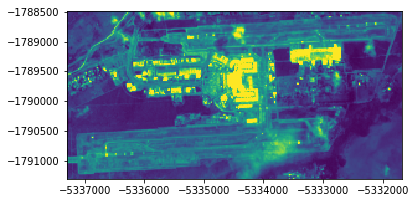

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x7fb97817e518>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x7fb97817ef60> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/usr/local/lib/python3.5/dist-packages/rasterio/gdal_data'.
DEBUG:rasterio._env:PROJ data files are available at built-in paths
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x7fb97817ef60>.
DEBUG:rasterio.env:Got a copy of environment <rasterio._env.GDALEnv object at 0x7fb97817ef60> options
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x7fb97817e518>
DEBUG:rasterio._base:Nodata success: 1, Nodata value: 0.000000
DEBUG:rasterio._base:Nodata success: 1, Nodata value: 0.000000
DEBUG:rasterio._base:Nodata success: 1, Nodata value: 0.000000
DEBUG:rasterio._base:Dataset <open DatasetReader name='/notebooks/data/output/sentinelca

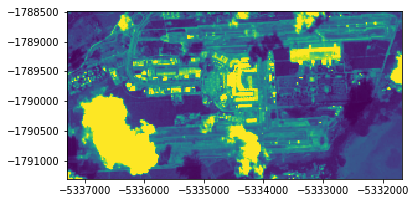

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x7fb97800c630>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x7fb978007160> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/usr/local/lib/python3.5/dist-packages/rasterio/gdal_data'.
DEBUG:rasterio._env:PROJ data files are available at built-in paths
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x7fb978007160>.
DEBUG:rasterio.env:Got a copy of environment <rasterio._env.GDALEnv object at 0x7fb978007160> options
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x7fb97800c630>
DEBUG:rasterio._base:Nodata success: 1, Nodata value: 0.000000
DEBUG:rasterio._base:Nodata success: 1, Nodata value: 0.000000
DEBUG:rasterio._base:Nodata success: 1, Nodata value: 0.000000
DEBUG:rasterio._base:Dataset <open DatasetReader name='/notebooks/data/output/sentinelca

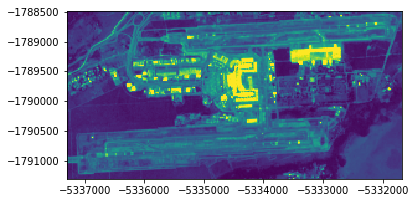

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x7fb976ea91d0>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x7fb976ea3320> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/usr/local/lib/python3.5/dist-packages/rasterio/gdal_data'.
DEBUG:rasterio._env:PROJ data files are available at built-in paths
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x7fb976ea3320>.
DEBUG:rasterio.env:Got a copy of environment <rasterio._env.GDALEnv object at 0x7fb976ea3320> options
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x7fb976ea91d0>
DEBUG:rasterio._base:Nodata success: 1, Nodata value: 0.000000
DEBUG:rasterio._base:Nodata success: 1, Nodata value: 0.000000
DEBUG:rasterio._base:Nodata success: 1, Nodata value: 0.000000
DEBUG:rasterio._base:Dataset <open DatasetReader name='/notebooks/data/output/sentinelca

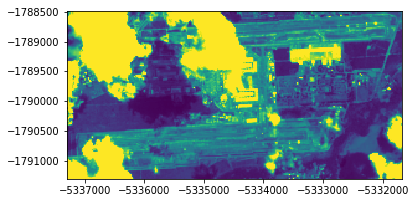

done


In [27]:
import logging
import os
from osgeo import gdal
import matplotlib.pyplot as plt
from sentinelloader import Sentinel2Loader
from shapely.geometry import Point, Polygon

sl = Sentinel2Loader('/notebooks/data/output/sentinelcache', 
                    os.environ['COPERNICUS_USER'], os.environ['COPERNICUS_PASSWORD'],
                    apiUrl='https://scihub.copernicus.eu/apihub/', showProgressbars=True, loglevel=logging.DEBUG)

area = [(-47.9458, -15.8841), (-47.9051, -15.8800),
        (-47.9359, -15.8625), (-47.8953, -15.8597)]

coords = Polygon(area)

d1 = '2019-04-15'
d2 = '2019-04-30'

geoTiffs = sl.getRegionHistory(coords, 'TCI', '20m', d1, d2, daysStep=5)

# showGeoTiffs(geoTiffs, geometries=geometries, labels=labels, cols=10, size=10,)

import rasterio
from rasterio.plot import show

for tiffs in geoTiffs:
    dataset = rasterio.open(tiffs)
    show(dataset)
print('done')

# for geoTiff in geoTiffs:
#     print('Desired image was prepared at')
#     print(geoTiff)
#     os.remove(geoTiff)

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x7fb97a8c2390>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x7fb97a8c2668> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/usr/local/lib/python3.5/dist-packages/rasterio/gdal_data'.
DEBUG:rasterio._env:PROJ data files are available at built-in paths
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x7fb97a8c2668>.
DEBUG:rasterio.env:Got a copy of environment <rasterio._env.GDALEnv object at 0x7fb97a8c2668> options
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x7fb97a8c2390>
DEBUG:rasterio._base:Nodata success: 1, Nodata value: 0.000000
DEBUG:rasterio._base:Nodata success: 1, Nodata value: 0.000000
DEBUG:rasterio._base:Nodata success: 1, Nodata value: 0.000000
DEBUG:rasterio._base:Dataset <open DatasetReader name='/notebooks/data/output/sentinelca

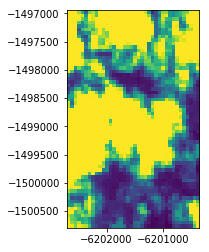

In [13]:
import rasterio
from rasterio.plot import show
path = '/notebooks/data/output/sentinelcache/tmp/2019-04-01-TCI-60m-308ade6be6e54e48aa2d3b2f11e9dc2e.tiff'
dataset = rasterio.open(path)
show(dataset)

In [16]:
! ls /notebooks/data/output/sentinelcache/tmp

16b83a1b91324eb2a24b74bd3d38edbd.jp2
2019-04-01-TCI-60m-308ade6be6e54e48aa2d3b2f11e9dc2e.tiff
2019-04-06-TCI-60m-7e2c7595be62410988e33d5c1935d494.tiff
2019-04-15-TCI-60m-ff7d0bbfe0544b8b8f4a91900f65469e.tiff
2019-04-20-TCI-60m-9bd9537d708b499b98e40d9e41a48b41.tiff
2019-04-25-TCI-60m-b06fb439b3f243dfa3d369b0eb31ec27.tiff
2019-04-30-TCI-60m-16a8be39a121462c88a134d967ed3ebe.tiff
4a4feb66495a4dc5a5509af11d6b1383.jp2
5a6808e4035b458da6dbe5e224f5d193.jp2
a142751608774d77815365e338169582.jp2
b77c23b80b664d81bdb0b3470a3c8582.jp2
df4cfbeda2174ee1916fc80b2a11faa0.jp2


In [2]:
pip list

Package                   Version               
------------------------- ----------------------
absl-py                   0.7.0                 
affine                    2.2.2                 
altair                    2.4.1                 
ansiwrap                  0.8.4                 
astor                     0.7.1                 
atomicwrites              1.3.0                 
attrs                     19.1.0                
backcall                  0.1.0                 
beautifulsoup4            4.7.1                 
bleach                    3.1.0                 
bokeh                     1.1.0                 
boto                      2.49.0                
boto3                     1.9.135               
botocore                  1.12.135              
branca                    0.3.1                 
bs4                       0.0.1                 
bz2file                   0.98                  
Cartopy                   0.17.0                
certifi             

Note: you may need to restart the kernel to use updated packages.


In [2]:
import folium
# folium_map = folium.Map([-17.175808940286416,-47.323007583618164], zoom_start=14, tiles="Stamen Watercolor")
# folium_map = folium.Map([-17.175808940286416,-47.323007583618164], zoom_start=14, tiles="CartoDB positron")
folium_map = folium.Map([-17.175808940286416,-47.323007583618164], zoom_start=14)
folium_map